In [1]:
import numpy as np
import matplotlib.pyplot as plt
from quantum_code import *
from classical_code import *
import stim
from tqdm import tqdm
from ldpc import BpDecoder, BpOsdDecoder
from ldpc.bplsd_decoder import BpLsdDecoder
# %load_ext snakeviz
import networkx as nx
from edge_coloring import edge_color_bipartite

6.615384615384615


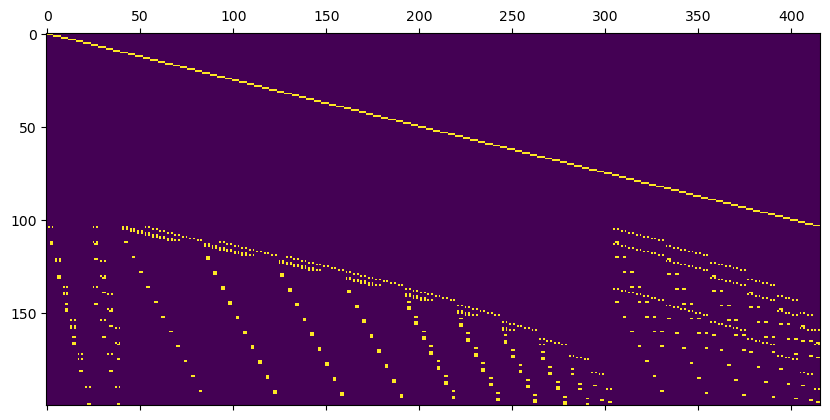

In [40]:
hgp_qcode = read_qcode("../codes/qcodes/expander/HGP_100_4/HGP_100_4.qcode")
qcode = hgp_qcode
qcode = read_qcode("../codes/qcodes/expander/HGP_100_4/HGP_C422_200_4.qcode")
# qcode = read_qcode("../codes/qcodes/HGP_C422_400_8.qcode")


# hgp_qcode = read_qcode("../codes/qcodes/expander/HGP_400_16/HGP_400_16.qcode")
# qcode = hgp_qcode
# qcode = read_qcode("../codes/qcodes/HGP_400_16/HGP_C422_800_16.qcode")


# hgp_qcode = read_qcode("../codes/qcodes/HGP_900_36/HGP_900_36.qcode")
# qcode = hgp_qcode
# qcode = read_qcode("../codes/qcodes/HGP_900_36/HGP_C422_1800_36.qcode")

# hgp_qcode = read_qcode("../codes/qcodes/HGP_1600_64/HGP_1600_64.qcode")
# qcode = hgp_qcode


hgp_qcode = read_qcode("../codes/qcodes/lacross/HGP_208_16/HGP_208_16.qcode")
qcode = hgp_qcode
qcode = read_qcode("../codes/qcodes/lacross/HGP_208_16/HGP_C422_416_16.qcode")

# concatenate_iceberg(qcode, 6, "../codes/qcodes/")
# concatenate_iceberg2(qcode, 4, "../codes/qcodes/")
# concatenate_steane(qcode, "../codes/qcodes/")


hgp_Hx, hgp_Hz, hgp_Lx, hgp_Lz, _ = hgp_qcode.to_numpy()
Hx, Hz, Lx, Lz, mapping = qcode.to_numpy()


qubit_error_rate = 0.001
meas_error_rate = 0.001

stab_type = False
concat = True if meas_error_rate else False
soft = True

H = Hx if stab_type else Hz
hgp_H = hgp_Hx if stab_type else hgp_Hz

qec_aug_dec_Hx = np.hstack([hgp_Hx, np.eye(hgp_Hx.shape[0], dtype=int)])
qec_aug_dec_Hz = np.hstack([hgp_Hz, np.eye(hgp_Hz.shape[0], dtype=int)])
qec_aug_channel_probs = [0.01]*hgp_H.shape[1] + [0.01]*(hgp_H.shape[0])

qec_dec_Hx = hgp_Hx
qec_dec_Hz = hgp_Hz
qec_channel_probs = [0.01]*hgp_H.shape[1]

L = Lx if stab_type else Lz

plt.matshow(H)

Hs = np.vstack([Hx, Hz])
print(np.mean(np.count_nonzero(Hs, axis=0)))

In [43]:
np.count_nonzero(Hz, axis=1)

array([ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  8,  8,  8,  8,  8,  8,  8,  8, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 10, 10,
       10, 10, 10, 10, 10, 10,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8], dtype=int64)

In [45]:
overlapping_x_generators = np.empty(qcode.qedxm, dtype=object)
for i in range(qcode.qedxm):
    tmp = np.array([], dtype=int)
    for j in range(qcode.qedxm,qcode.xm):
        if np.any(Hx[i] & Hx[j]): tmp = np.append(tmp, j)
    overlapping_x_generators[i] = tmp

overlapping_z_generators = np.empty(qcode.qedxm, dtype=object)
for i in range(qcode.qedzm):
    tmp = np.array([], dtype=int)
    for j in range(qcode.qedzm,qcode.zm):
        if np.any(Hz[i] & Hz[j]): tmp = np.append(tmp, j)
    overlapping_z_generators[i] = tmp

def get_overlapping(measurements, gen_type=False, not_overlapping=False):
    overlapping_generators = overlapping_x_generators if gen_type else overlapping_z_generators
    gens_to_measure = set()
    for g in np.where(measurements)[0]:
        gens_to_measure |= set(overlapping_generators[g])

    if not_overlapping:
        return np.array(list(set(np.arange(qcode.qedxm,qcode.xm)) ^ gens_to_measure))
    else:
        return np.array(list(gens_to_measure))

def iceberglogicals(n):
    icebergX = np.zeros(shape=(n-2,2), dtype=int)
    icebergZ = np.zeros(shape=(n-2,2), dtype=int)

    for i in range(n-2):
        icebergX[i] = np.array([0,i+1])
        icebergZ[i] = np.array([i+1,n-1])

    return icebergX, icebergZ
icebergX, icebergZ = iceberglogicals(4)

In [46]:
qec_aug_decZ = BpDecoder(
    qec_aug_dec_Hz,
    channel_probs=qec_aug_channel_probs,
    bp_method="ps",
    max_iter=30,
    schedule="serial",
    # lsd_method="lsd0"
    # osd_order=4 #the osd search depth
)

qec_decZ = BpLsdDecoder(
    qec_dec_Hz,
    channel_probs=qec_channel_probs,
    bp_method="ps",
    max_iter=30,
    schedule="serial",
    lsd_method="lsd_cs",
    lsd_order=4 #the osd search depth
)

qec_aug_decX = BpDecoder(
    qec_aug_dec_Hx,
    channel_probs=qec_aug_channel_probs,
    bp_method="ps",
    max_iter=30,
    schedule="serial",
    # lsd_method="lsd0"
    # osd_order=4 #the osd search depth
)

qec_decX = BpLsdDecoder(
    qec_dec_Hx,
    channel_probs=qec_channel_probs,
    bp_method="ps",
    max_iter=30,
    schedule="serial",
    lsd_method="lsd_cs",
    lsd_order=4 #the osd search depth
)



def decode(curr_synd, augment, stab_type):
    H = Hx if stab_type else Hz
    guessed_error = np.zeros(H.shape[1], dtype=int)
    qec_aug_dec = qec_aug_decX if stab_type else qec_aug_decZ
    qec_dec = qec_decX if stab_type else qec_decZ

    if not concat:
        # QEC only
        if augment:
            guessed_error ^= qec_aug_dec.decode(curr_synd[qcode.qedzm:])[:hgp_H.shape[1]]
        else:
            guessed_error ^= qec_dec.decode(curr_synd[qcode.qedzm:])
    elif concat:
        # QED + QEC
        curr_qed_synd = curr_synd[:qcode.qedxm]
        curr_hgp_synd = curr_synd[qcode.qedxm:]

        block_correction = np.array([0,0,0,1], dtype=int) if stab_type else np.array([1,0,0,0], dtype=int)
        corrections = np.concatenate([block_correction if x == 1 else np.zeros(4, dtype=int) for x in curr_qed_synd])
        guessed_error ^= corrections

        # pot_corrections = np.eye(4, dtype=int)
        # corrections = np.concatenate([pot_corrections[np.random.randint(0,4)] if x == 1 else np.zeros(4, dtype=int) for x in curr_qed_synd])
        # guessed_error ^= corrections
        # curr_hgp_synd ^= ((H @ corrections) % 2)[qcode.qedxm:]

        #######################
        if soft:
            new_channel_probs = 0.01 * np.ones(hgp_H.shape[1])
            new_channel_probs[mapping[curr_qed_synd == 1].flatten()] = 0.25
            if augment:
                new_channel_probs = np.concatenate([new_channel_probs, [0.01]*hgp_H.shape[0]])
                qec_aug_dec.update_channel_probs(new_channel_probs)
            else:
                qec_dec.update_channel_probs(new_channel_probs)
        ########################

        if augment:
            logical_correction = qec_aug_dec.decode(curr_hgp_synd)[:hgp_H.shape[1]]
        else:
            logical_correction = qec_dec.decode(curr_hgp_synd)[:hgp_H.shape[1]]

        physical_correction = np.zeros(Hx.shape[1], dtype=int)

        for c in np.where(logical_correction)[0]:
                iceberg_block = np.where(mapping == c)[0][0]
                iceberg_log = np.where(mapping == c)[1][0]
                if stab_type:
                        physical_correction[icebergZ[iceberg_log]+(4*iceberg_block)] ^= 1
                else:
                        physical_correction[icebergX[iceberg_log]+(4*iceberg_block)] ^= 1

        guessed_error ^= physical_correction
    return guessed_error


overlapping_x_generators = np.empty(qcode.qedxm, dtype=object)
for i in range(qcode.qedxm):
    tmp = np.array([], dtype=int)
    for j in range(qcode.qedxm,qcode.xm):
        if np.any(Hx[i] & Hx[j]): tmp = np.append(tmp, j)
    overlapping_x_generators[i] = tmp

overlapping_z_generators = np.empty(qcode.qedxm, dtype=object)
for i in range(qcode.qedzm):
    tmp = np.array([], dtype=int)
    for j in range(qcode.qedzm,qcode.zm):
        if np.any(Hz[i] & Hz[j]): tmp = np.append(tmp, j)
    overlapping_z_generators[i] = tmp

def get_overlapping(measurements, gen_type=False, not_overlapping=False):
    overlapping_generators = overlapping_x_generators if gen_type else overlapping_z_generators
    gens_to_measure = set()
    for g in np.where(measurements)[0]:
        gens_to_measure |= set(overlapping_generators[g])

    if not_overlapping:
        return np.array(list(set(np.arange(qcode.qedxm,qcode.xm)) ^ gens_to_measure))
    else:
        return np.array(list(gens_to_measure))


cn = qcode.n
cmx = qcode.xm
cmz = qcode.zm
data_qbts = np.arange(cn)
x_checks = np.arange(cn,cn+cmx)
z_checks = np.arange(cn+cmx,cn+cmx+cmz)

precomputed_x_checks_circuits = np.empty(cmx, dtype=object)
for x in np.arange(qcode.xm):
    c = stim.Circuit()
    gen_qbts = data_qbts[np.where(Hx[x])[0]]
    for qbt in gen_qbts:
        path_qbts = [x_checks[x], qbt]
        c.append("CNOT", path_qbts)
        c.append("DEPOLARIZE2", path_qbts, qubit_error_rate)
    precomputed_x_checks_circuits[x] = c

def prepare_x_checks(checks):
    c = stim.Circuit()
    if len(checks) == 0: return c
    c.append("H", [x_checks[x_check] for x_check in checks])
    c.append("DEPOLARIZE1", [x_checks[x_check] for x_check in checks], qubit_error_rate)
    for x in checks:
        c += precomputed_x_checks_circuits[x]
    c.append("H", [x_checks[x_check] for x_check in checks])
    c.append("DEPOLARIZE1", [x_checks[x_check] for x_check in checks], qubit_error_rate)
    return c

precomputed_z_checks_circuits = np.empty(cmz, dtype=object)
for z in np.arange(qcode.zm):
    c = stim.Circuit()
    gen_qbts = data_qbts[np.where(Hz[z])[0]]
    for qbt in gen_qbts:
        path_qbts = [qbt, z_checks[z]]
        c.append("CNOT", path_qbts)
        c.append("DEPOLARIZE2", path_qbts, qubit_error_rate)
    precomputed_z_checks_circuits[z] = c

def prepare_z_checks(checks):
    c = stim.Circuit()
    if len(checks) == 0: return c
    for z in checks:
        c += precomputed_z_checks_circuits[z]
    return c

precomputed_qed_checks_circuits = np.empty(qcode.qedxm, dtype=object)
for zx in np.arange(qcode.qedxm):
    c = stim.Circuit()

    gen_qbts = data_qbts[np.where(Hz[zx])[0]]
    c.append("H", x_checks[zx])
    c.append("DEPOLARIZE1", x_checks[zx], qubit_error_rate)

    # ONLY WORKS FOR 422 RIGHT NOW
    c.append("CNOT", [x_checks[zx], gen_qbts[0]])
    c.append("DEPOLARIZE2", [x_checks[zx], gen_qbts[0]], qubit_error_rate)
    c.append("CNOT", [gen_qbts[0], z_checks[zx]])
    c.append("DEPOLARIZE2", [gen_qbts[0], z_checks[zx]], qubit_error_rate)
    c.append("CNOT", [gen_qbts[1], z_checks[zx]])
    c.append("DEPOLARIZE2", [gen_qbts[1], z_checks[zx]], qubit_error_rate)
    c.append("CNOT", [x_checks[zx], gen_qbts[1]])
    c.append("DEPOLARIZE2", [x_checks[zx], gen_qbts[1]], qubit_error_rate)

    c.append("CNOT", [x_checks[zx], gen_qbts[2]])
    c.append("DEPOLARIZE2", [x_checks[zx], gen_qbts[2]], qubit_error_rate)
    c.append("CNOT", [gen_qbts[2], z_checks[zx]])
    c.append("DEPOLARIZE2", [gen_qbts[2], z_checks[zx]], qubit_error_rate)
    c.append("CNOT", [gen_qbts[3], z_checks[zx]])
    c.append("DEPOLARIZE2", [gen_qbts[3], z_checks[zx]], qubit_error_rate)
    c.append("CNOT", [x_checks[zx], gen_qbts[3]])
    c.append("DEPOLARIZE2", [x_checks[zx], gen_qbts[3]], qubit_error_rate)

    c.append("H", x_checks[zx])
    c.append("DEPOLARIZE1", x_checks[zx], qubit_error_rate)
    precomputed_qed_checks_circuits[zx] = c

def prepare_qed_circuits():
    c = stim.Circuit()
    for zx in np.arange(qcode.qedxm):
        c += precomputed_qed_checks_circuits[zx]
    return c


class Simulation:
    def __init__(self, num_rounds, stab_type, concat=True, adaptive=True):
        self.num_rounds = num_rounds
        self.stab_type = stab_type
        self.curr_round = 1
        self.concat = concat
        self.adaptive = adaptive

        self.z_check_history = np.ones(cmz, dtype=int)
        self.x_check_history = np.ones(cmx, dtype=int)
        self.z_syndrome_history = np.zeros(shape=(num_rounds+2, cmz), dtype=int)
        self.x_syndrome_history = np.zeros(shape=(num_rounds+2, cmx), dtype=int)
        self.z_observables = np.zeros(qcode.k, dtype=int)
        self.x_observables = np.zeros(qcode.k, dtype=int)
        self.errors = []

        self.c = stim.Circuit()
        self.s = stim.TableauSimulator()
        self.f = stim.FlipSimulator(batch_size=1, disable_stabilizer_randomization=True, num_qubits=cn+cmx+cmz)

        if self.stab_type:
            self.c.append("H", [qbt for qbt in data_qbts])
            self.c += prepare_z_checks(np.arange(cmz)).without_noise()
            for i, z_check in enumerate(np.arange(cmz)):
                self.c.append("MR", z_checks[z_check])
        else:
            self.c += prepare_x_checks(np.arange(cmx)).without_noise()
            for i, x_check in enumerate(np.arange(cmx)):
                self.c.append("MR", x_checks[x_check])

        self.s.do(self.c)
        if self.stab_type:
            self.z_syndrome_history[0] = self.s.current_measurement_record()
        else:
            self.x_syndrome_history[0] = self.s.current_measurement_record()


    def QED(self):
        def measure_z_qed_checks():
            c = stim.Circuit()
            c.append("X_ERROR", [z_checks[z_check] for z_check in np.arange(qcode.qedzm)], meas_error_rate)
            c.append("MR", [z_checks[z_check] for z_check in np.arange(qcode.qedzm)])
            c.append("X_ERROR", [z_checks[z_check] for z_check in np.arange(qcode.qedzm)], meas_error_rate)
            return c

        def measure_x_qed_checks():
            c = stim.Circuit()
            c.append("X_ERROR", [x_checks[x_check] for x_check in np.arange(qcode.qedxm)], meas_error_rate)
            c.append("MR", [x_checks[x_check] for x_check in np.arange(qcode.qedxm)])
            c.append("X_ERROR", [x_checks[x_check] for x_check in np.arange(qcode.qedxm)], meas_error_rate)
            return c

        c = stim.Circuit()
        c += prepare_qed_circuits()
        if self.stab_type:
            c += measure_x_qed_checks()
            c += measure_z_qed_checks()
        else:
            c += measure_z_qed_checks()
            c += measure_x_qed_checks()
        return c

    def QEC(self):
        def measure_z_qec_checks(curr_z_checks):
            c = stim.Circuit()
            c += prepare_z_checks(curr_z_checks)
            c.append("X_ERROR", [z_checks[z_check] for z_check in curr_z_checks], meas_error_rate)
            c.append("MR", [z_checks[z_check] for z_check in curr_z_checks])
            c.append("X_ERROR", [z_checks[z_check] for z_check in curr_z_checks], meas_error_rate)
            return c

        def measure_x_qec_checks(curr_x_checks):
            c = stim.Circuit()
            c += prepare_x_checks(curr_x_checks)
            c.append("X_ERROR", [x_checks[x_check] for x_check in curr_x_checks], meas_error_rate)
            c.append("MR", [x_checks[x_check] for x_check in curr_x_checks])
            c.append("X_ERROR", [x_checks[x_check] for x_check in curr_x_checks], meas_error_rate)
            return c

        c = stim.Circuit()
        if self.stab_type:
            c += measure_x_qec_checks(self.curr_x_checks)
            c += measure_z_qec_checks(self.curr_z_checks)
        else:
            c += measure_z_qec_checks(self.curr_z_checks)
            c += measure_x_qec_checks(self.curr_x_checks)
        return c

    def final_synd_and_observables(self):
        c = stim.Circuit()

        if self.stab_type: c.append("H", [qbt for qbt in data_qbts])
        c.append("M", data_qbts)

        self.f.do(c)
        self.c += c

        # meas = self.s.current_measurement_record()
        meas = self.f.get_measurement_flips().flatten()
        H = Hx if self.stab_type else Hz
        for i in range(H.shape[0]):
            incl_qbts = np.where(H[i])[0]
            incl_qbts = np.array([j-cn for j in incl_qbts])

            if self.stab_type:
                self.x_syndrome_history[-1][i] = np.sum(np.take(meas, incl_qbts)) % 2
            else:
                self.z_syndrome_history[-1][i] = np.sum(np.take(meas, incl_qbts)) % 2

        for i, logical in enumerate(Lx if self.stab_type else Lz):
            incl_qbts = np.where(logical)[0]
            incl_qbts = [j-cn for j in incl_qbts]

            if self.stab_type:
                self.x_observables[i] = (np.sum(np.take(meas, incl_qbts)) % 2)
            else:
                self.z_observables[i] = (np.sum(np.take(meas, incl_qbts)) % 2)

        if self.stab_type:
            final_correction = decode(self.x_syndrome_history[-1], 0, True)
            self.x_observables ^= (Lx @ final_correction) % 2
        else:
            final_correction = decode(self.z_syndrome_history[-1], 0, False)
            self.z_observables ^= (Lz @ final_correction) % 2


    def simulate(self):
        tmp = stim.Circuit()
        tmp.append("DEPOLARIZE1", data_qbts, qubit_error_rate)
        # self.f.do(tmp)
        for _ in range(1, self.num_rounds+1):
            # self.s.depolarize1(*data_qbts, p=qubit_error_rate)
            self.f.do(tmp)

            self.curr_z_checks = np.zeros(cmz)
            self.curr_x_checks = np.zeros(cmx)
            if (not self.adaptive):
                self.curr_z_checks = np.arange(cmz)
                self.curr_x_checks = np.arange(cmx)
            else:
                QED_circuit = self.QED()
                self.s.do(QED_circuit.without_noise())
                # self.f.do(QED_circuit)

                for g in QED_circuit:
                    self.f.do(g)
                    # if (g.name == "DEPOLARIZE2") or (g.name == "DEPOLARIZE1") or (g.name == "X_ERROR"):
                        # self.errors.append((str(g), self.f.peek_pauli_flips()))
                self.c += QED_circuit

                # meas = self.s.current_measurement_record()
                meas = self.f.get_measurement_flips().flatten()
                if self.stab_type:
                    self.x_syndrome_history[self.curr_round][:qcode.qedxm] = meas[-(qcode.qedxm+qcode.qedzm):-qcode.qedxm]
                    self.z_syndrome_history[self.curr_round][:qcode.qedzm] = meas[-qcode.qedzm:]

                    z_qed_synd_diff = self.z_syndrome_history[self.curr_round][:qcode.qedzm] ^ self.z_syndrome_history[0][:qcode.qedzm]
                    x_qed_synd_diff = self.x_syndrome_history[self.curr_round][:qcode.qedxm]
                    self.curr_z_checks = sorted(get_overlapping(z_qed_synd_diff, False))
                    self.curr_x_checks = sorted(get_overlapping(x_qed_synd_diff, True))
                else:
                    self.x_syndrome_history[self.curr_round] = self.x_syndrome_history[self.curr_round-1]
                    self.z_syndrome_history[self.curr_round][:qcode.qedzm] = meas[-(qcode.qedzm+qcode.qedxm):-qcode.qedzm]
                    self.x_syndrome_history[self.curr_round][:qcode.qedxm] ^= meas[-qcode.qedxm:]

                    x_qed_synd_diff = meas[-qcode.qedxm]
                    z_qed_synd_diff = self.z_syndrome_history[self.curr_round][:qcode.qedzm]
                    self.curr_x_checks = sorted(get_overlapping(x_qed_synd_diff, True))
                    self.curr_z_checks = sorted(get_overlapping(z_qed_synd_diff, False))

                    # if (_ > 1) and ((_ - 1) % 10 == 0):
            self.curr_z_checks = np.arange(qcode.qedxm, cmz)
            self.curr_x_checks = np.arange(qcode.qedxm, cmx)


            confirmation_z = np.concatenate([np.ones(qcode.qedzm, dtype=int), np.zeros(cmz-qcode.qedzm, dtype=int)])
            confirmation_z[self.curr_z_checks] = 1
            confirmation_x = np.concatenate([np.ones(qcode.qedxm, dtype=int), np.zeros(cmx-qcode.qedxm, dtype=int)])
            confirmation_x[self.curr_x_checks] = 1
            self.z_check_history = np.vstack([self.z_check_history, confirmation_z])
            self.x_check_history = np.vstack([self.x_check_history, confirmation_x])

            # self.errors.append("OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO")
            QEC_circuit = self.QEC()
            self.s.do_circuit(QEC_circuit.without_noise())
            # self.f.do(QEC_circuit)
            for g in QEC_circuit:
                    self.f.do(g)
                    # if (g.name == "DEPOLARIZE2") or (g.name == "DEPOLARIZE1") or (g.name == "X_ERROR"):
                        # self.errors.append((str(g), self.f.peek_pauli_flips()))
            self.c += QEC_circuit

            # meas = self.s.current_measurement_record()
            meas = self.f.get_measurement_flips().flatten()

            lookback = lambda x: -len(x) if len(x) else None
            if self.stab_type:
                if len(self.curr_x_checks):
                    self.x_syndrome_history[self.curr_round][self.curr_x_checks] = meas[lookback(np.concatenate([self.curr_x_checks, self.curr_z_checks])):
                                                                        lookback(self.curr_z_checks)]
                if len(self.curr_z_checks):
                    self.z_syndrome_history[self.curr_round][self.curr_z_checks] = meas[lookback(self.curr_z_checks):]
            else:
                if len(self.curr_z_checks):
                    self.z_syndrome_history[self.curr_round][self.curr_z_checks] = meas[lookback(np.concatenate([self.curr_z_checks, self.curr_x_checks])):
                                                                        lookback(self.curr_x_checks)]
                if len(self.curr_x_checks):
                    self.x_syndrome_history[self.curr_round][self.curr_x_checks] ^= meas[lookback(self.curr_x_checks):]

            self.errors.append(self.f.peek_pauli_flips())
            if self.stab_type:
                guessed_z_error = decode(self.x_syndrome_history[self.curr_round], 1, True)
                self.f.z(*np.where(guessed_z_error)[0])
                guessed_x_error = decode(self.z_syndrome_history[self.curr_round] ^ self.z_syndrome_history[0], 1, False)
                self.f.x(*np.where(guessed_x_error)[0])
            else:
                correction_circuit = stim.Circuit()
                guessed_x_error = decode(self.z_syndrome_history[self.curr_round], 1, False)
                correction_circuit.append("X_ERROR", np.where(guessed_x_error)[0], 1)
                guessed_z_error = decode(self.x_syndrome_history[self.curr_round] ^ self.x_syndrome_history[0], 1, True)
                correction_circuit.append("Z_ERROR", np.where(guessed_z_error)[0], 1)
                self.f.do(correction_circuit)
            self.errors.append(self.f.peek_pauli_flips())

            self.curr_round += 1

#         self.final_synd_and_observables()

In [22]:
concat = True if qcode.qedxm else False
adaptive = True if qcode.qedxm else False
# adaptive = False


num_iters = 10
num_rounds = 100
successes = 0
num_gens = []
for i in tqdm(range(num_iters)):
    s = Simulation(num_rounds, stab_type, concat=concat, adaptive=adaptive)
    s.simulate()
    c = s.c

    if np.any(s.z_observables):
        pass
    else:
        successes += 1

print(successes)

100%|██████████| 10/10 [00:10<00:00,  1.08s/it]

10


In [23]:
s.errors[-1]

[stim.PauliString("+XZZXYYZ_XX_ZXXXY____Y_XZYXYY_YY_X__YXZYZXXZZXYZ___XYZ__ZY_YZXYXY__XYXZXZ_Y_XZZXXYZXZZXZXXZYZ_Y_YZXXZXYYY___ZYXZ_YYYYXY_ZXZ_XXZXZXZX_X_XZZZZZZX_YYXZ_XXXYX_XZZ__ZXXXY_XX__YYZ_XX_XXZZYX__Y__XYZ_XZ__ZYY__________Z______ZZ_Z__Z_Z_Z_Z______Z_____Z___ZZZ__Z____Z__Z_Z____Z_ZZ___ZZ____Z_______ZZ__Z__Z__Z___Z_____Z_Z___ZZ______Z_ZZ________Z___________________ZZZ__ZZZ____Z_ZZ__ZZ_Z__Z_____Z___Z_____Z_ZZ_")]

In [24]:
for i in range(0, len(s.errors), 2):
    print(i, s.errors[i])
    print(i, s.errors[i+1])
    print()

0 [stim.PauliString("+__________________________________________________________________________ZZ__________________ZZ______________ZZ_________________________Z_Z_____________________________________________Z_Z_____Z_Z_Z_Z_____________________________________________________________________________________________________________________________________________________________________________________________Z______")]
0 [stim.PauliString("+__________________________________________________________________________ZZ__________________ZZ______________ZZ_________________________Z_Z_____________________________________________Z_Z_____Z_Z_Z_Z_____________________________________________________________________________________________________________________________________________________________________________________________Z______")]

2 [stim.PauliString("+____________________________________________________________________________________YZZZ_____________________________________________

In [175]:
errors = np.zeros(cn, dtype=int)
errors[2] = 1

(Hz @ errors) % 2

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [211]:
for g in s.QED():
    if (g.name == "DEPOLARIZE2") or (g.name == "DEPOLARIZE1") or (g.name == "X_ERROR"):
        print(str(g))

DEPOLARIZE1(0.001) 200
DEPOLARIZE2(0.001) 200 0
DEPOLARIZE2(0.001) 0 298
DEPOLARIZE2(0.001) 1 298
DEPOLARIZE2(0.001) 200 1
DEPOLARIZE2(0.001) 200 2
DEPOLARIZE2(0.001) 2 298
DEPOLARIZE2(0.001) 3 298
DEPOLARIZE2(0.001) 200 3
DEPOLARIZE1(0.001) 200
DEPOLARIZE1(0.001) 201
DEPOLARIZE2(0.001) 201 4
DEPOLARIZE2(0.001) 4 299
DEPOLARIZE2(0.001) 5 299
DEPOLARIZE2(0.001) 201 5
DEPOLARIZE2(0.001) 201 6
DEPOLARIZE2(0.001) 6 299
DEPOLARIZE2(0.001) 7 299
DEPOLARIZE2(0.001) 201 7
DEPOLARIZE1(0.001) 201
DEPOLARIZE1(0.001) 202
DEPOLARIZE2(0.001) 202 8
DEPOLARIZE2(0.001) 8 300
DEPOLARIZE2(0.001) 9 300
DEPOLARIZE2(0.001) 202 9
DEPOLARIZE2(0.001) 202 10
DEPOLARIZE2(0.001) 10 300
DEPOLARIZE2(0.001) 11 300
DEPOLARIZE2(0.001) 202 11
DEPOLARIZE1(0.001) 202
DEPOLARIZE1(0.001) 203
DEPOLARIZE2(0.001) 203 12
DEPOLARIZE2(0.001) 12 301
DEPOLARIZE2(0.001) 13 301
DEPOLARIZE2(0.001) 203 13
DEPOLARIZE2(0.001) 203 14
DEPOLARIZE2(0.001) 14 301
DEPOLARIZE2(0.001) 15 301
DEPOLARIZE2(0.001) 203 15
DEPOLARIZE1(0.001) 203
DEPO

In [308]:
s.x_check_history

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [445]:
np.count_nonzero(H, axis=1)

array([ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14], dtype=int64)

In [27]:
c = stim.Circuit()
c.append("PAULI_CHANNEL_1", 0, 0)

ValueError: Gate PAULI_CHANNEL_1 was given 1 parens arguments (0) but takes 3 parens arguments.

In [48]:
precomputed_qed_checks_circuits[-1]

stim.Circuit('''
    H 249
    DEPOLARIZE1(0.001) 249
    CX 249 196
    DEPOLARIZE2(0.001) 249 196
    CX 196 347
    DEPOLARIZE2(0.001) 196 347
    CX 197 347
    DEPOLARIZE2(0.001) 197 347
    CX 249 197
    DEPOLARIZE2(0.001) 249 197
    CX 249 198
    DEPOLARIZE2(0.001) 249 198
    CX 198 347
    DEPOLARIZE2(0.001) 198 347
    CX 199 347
    DEPOLARIZE2(0.001) 199 347
    CX 249 199
    DEPOLARIZE2(0.001) 249 199
    H 249
    DEPOLARIZE1(0.001) 249
''')